<a href="https://colab.research.google.com/github/czs-school-23/bayesian-ml/blob/main/stellar_spectra_example_emily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup
Firstly, let's import everything we'll need.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import os
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

Next, we need to download the repository containing our data.

In [ ]:
!git clone "https://github.com/czs-school-23/bayesian-ml"
os.chdir("bayesian-ml")

fatal: destination path 'bayesian-ml' already exists and is not an empty directory.


Now, let's load the data we'll be using.

In [ ]:
list(Path(".").glob("data/*/*"))

[PosixPath('data/curve/curve.py'),
 PosixPath('data/curve/data.npy'),
 PosixPath('data/curve/curve.png'),
 PosixPath('data/stellar_spectra/spectra.npy'),
 PosixPath('data/stellar_spectra/wavelengths.npy'),
 PosixPath('data/stellar_spectra/properties.csv')]

In [ ]:
spectra = np.load("data/stellar_spectra/spectra.npy")
properties = pd.read_csv("data/stellar_spectra/properties.csv")

# In log angstroms by default. Converted to nm because personal preference =)
wavelengths = np.exp(np.load("data/stellar_spectra/wavelengths.npy")) / 10

# Inspecting the data
Let's take a look at what we're working with!

These are the parameters of the first five spectra:

In [ ]:
properties.head()

,t_eff,log_g,feh,afe,v_mic,phase,age,v_macro,h_abundance,he_abundance,filename
0,4932.1777,4.274360,0.5,0.419682,3.008605,-1,7.10,0.0,0.914398,0.079920,b'X0000'
1,4670.5576,0.960434,0.5,-0.099054,2.158830,0,7.15,0.0,0.919236,0.078108,b'X0001'
2,6180.6104,4.077509,0.5,0.323485,3.652777,-1,7.20,0.0,0.915778,0.079401,b'X0002'
3,6798.6284,4.111562,0.5,0.336346,2.158780,0,7.20,0.0,0.915610,0.079464,b'X0003'
4,4129.8010,0.905774,0.5,0.176030,1.875668,0,7.20,0.0,0.917379,0.078801,b'X0004'


## Histograms

These are overall histograms of the parameters we'd like to fit: t_eff, log_g, and feh.

<Axes: >

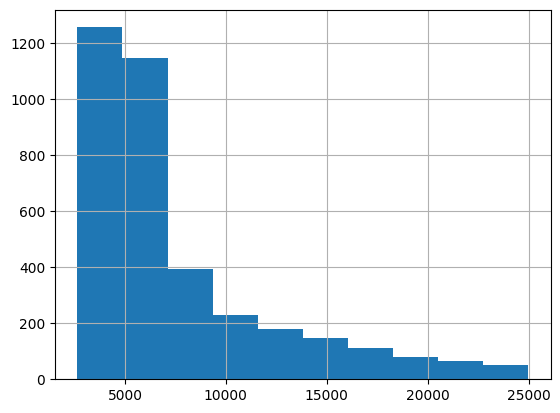

In [ ]:
properties['t_eff'].hist()

<Axes: >

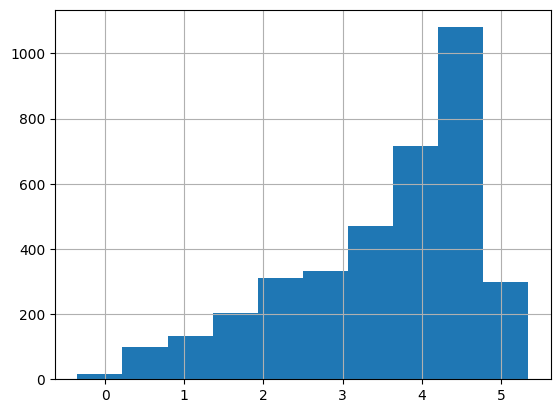

In [ ]:
properties['log_g'].hist()

<Axes: >

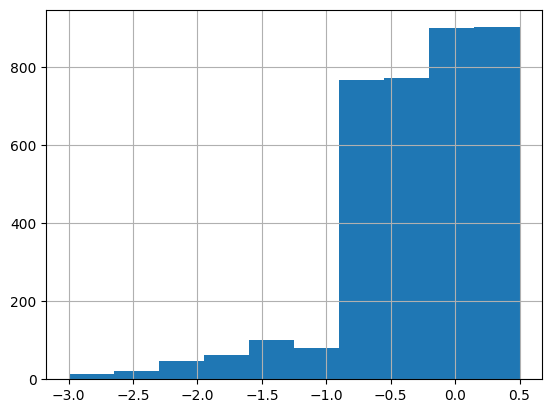

In [ ]:
properties['feh'].hist()

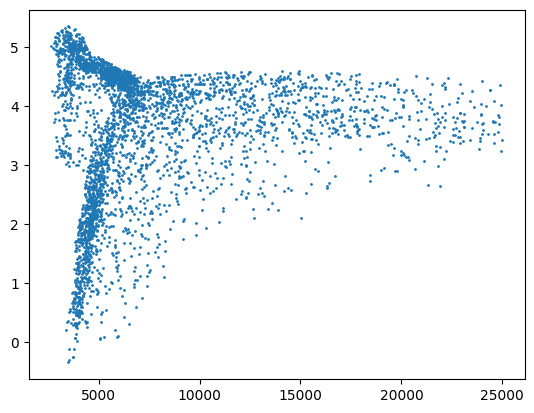

In [ ]:
plt.scatter(properties["t_eff"], properties["log_g"], s=1)

## Spectra
Here are a few of the spectra, plotted to have the same area:

Text(0.5, 0, 'Wavelength (nm)')

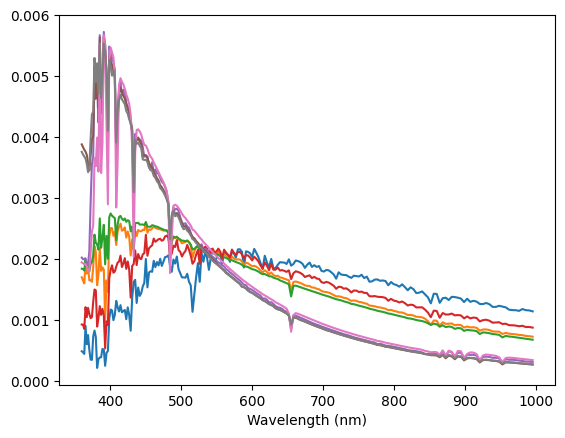

In [ ]:
for s in spectra[::500]:
  plt.plot(wavelengths, s / np.trapz(s, wavelengths))

plt.xlabel("Wavelength (nm)")

# Preprocessing
Before going any further, we should standardise all the spectral data a bit.

We'll give everything a zero median and unit inter-quartile range (a bit more robust than zero mean unit variance).

In [ ]:
input_scaler = RobustScaler()
output_scaler = RobustScaler()

x = spectra.copy()
y = properties[["t_eff", "log_g", "feh"]].to_numpy().copy()

x_scaled = input_scaler.fit_transform(x)
y_scaled = output_scaler.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, random_state=42, train_size=0.8)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2928, 210), (732, 210), (2928, 3), (732, 3))

We have about 3000 examples to train on and 730 to test on.

# A basic network
Let's try making a basic network to infer properties with these spectra.

In [31]:
model = keras.Sequential([
    keras.layers.Reshape((210, 1)),
    keras.layers.Convolution1D(40, 7, 2, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dense(3)
])

In [36]:
model.compile(
    loss="MeanSquaredError",
    metrics=['MeanSquaredError'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    epochs=300,
    verbose=1
)

Epoch 1/300
92/92 [==============================] - 3s 8ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 2/300
92/92 [==============================] - 0s 5ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 3/300
92/92 [==============================] - 0s 5ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 4/300
92/92 [==============================] - 0s 4ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 5/300
92/92 [==============================] - 0s 4ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 6/300
92/92 [==============================] - 0s 4ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 7/300
92/92 [===============

In [37]:
y_predicted = output_scaler.inverse_transform(model(x_test))
y_targets = output_scaler.inverse_transform(y_test)

[Text(0.5, 1.0, '[Fe/H]')]

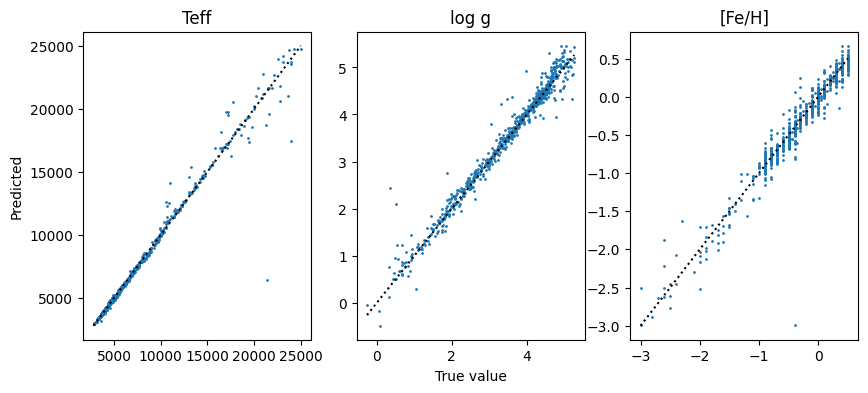

In [38]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 4))

for i in range(3):
    ax[i].scatter(y_targets[:, i], y_predicted[:, i], s=1)
    min, max = y_targets[:, i].min(), y_targets[:, i].max()
    ax[i].plot([min, max], [min, max], 'k:')

ax[0].set(title="Teff", ylabel="Predicted")
ax[1].set(title="log g", xlabel="True value")
ax[2].set(title="[Fe/H]")